In [5]:
import operator
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.colors
import holoviews as hv
#from holoviews import opts

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve,\
                            confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import os
import boto3
from sklearn.externals import joblib

#hv.extension('bokeh')


########################################
######### HELPER FUNCTIONS #############
########################################

def plot_single_variable_histogram(df, *, column_name='V1', binning_method=10):
    _, bins = np.histogram(df[column_name].tolist(), bins=binning_method)
        
    plt.figure(figsize=(14,5))
    
    plt.subplot('121')
    plt.hist(df[df['Class']==0][column_name].tolist(), bins=bins, label = '0')
    plt.legend()
    plt.title(f'Normal Transactions - Column = {column_name}')
    plt.yscale('log')
    
    plt.subplot('122')
    plt.hist(df[df['Class']==1][column_name].tolist(), bins=bins, label = '1')
    plt.legend()
    plt.title(f'Fraudulent Transactions - Column = {column_name}')
    plt.yscale('log')

def preprocess_pca(df, pca_cols, *, pca_n_components=2):
    df_pca = df[pca_cols]

    scaler = StandardScaler(with_mean=True, with_std=True)
    df_pca = scaler.fit_transform(df_pca)

    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_pca)    

    df_pca = pd.DataFrame(df_pca)
    df_pca['Time'] = df['Time']
    df_pca['Class'] = df['Class']
    
    return df_pca, scaler, pca
    
def create_validation_sets(df, train_size=0.75):
    #sort dataframe by Time
    df.sort_values(by='Time', inplace=True)

    n_samples = df.shape[0]

    if train_size < 0 or train_size > 1:
        raise ValueError('Please ensure train_size is between 0 and 1')

    n_train = int(train_size * n_samples)

    df_train = df.iloc[0:n_train] #first n_train rows are train
    df_test = df.iloc[n_train:] #rest is test

    #ensure no overlap in time between train and test
    assert(np.min(np.array(df_test.index)) > np.max(np.array(df_train.index)))    
    
    return df_train, df_test
    
def build_model(model, features_train, target_train, features_test, target_test):
    '''Helper function to train model
    '''
    if 'Class' in features_train or 'Class' in features_test:
        raise ValueError("Column Class shouldn't be in features")
    
    model.fit(features_train, target_train)

    pred_train = model.predict_proba(features_train)
    pred_test = model.predict_proba(features_test)

    #pr curve
    precision_train, recall_train, thresholds_train = precision_recall_curve(target_train, pred_train[:,1])
    precision_test, recall_test, thresholds_test = precision_recall_curve(target_test, pred_test[:,1])

    #roc curve
    fpr_train, tpr_train, _ = roc_curve(target_train, pred_train[:,1])
    fpr_test, tpr_test, _ = roc_curve(target_test, pred_test[:,1])
    
    #area under pr curve
    auc_pr_train = average_precision_score(target_train, pred_train[:,1], average=None)
    auc_pr_test = average_precision_score(target_test, pred_test[:,1], average=None)    
    
    #auc roc
    auc_train = roc_auc_score(target_train, pred_train[:,1])
    auc_test = roc_auc_score(target_test, pred_test[:,1])
    
    plt.figure(figsize=(10,16))
    
    plt.subplot(211)
    plt.plot(recall_train, precision_train, label='train')
    plt.plot(recall_test, precision_test, label='test')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.title(f'Train Area = {auc_pr_train: .3f} - Test Area = {auc_pr_test: .3f}')
 
    plt.subplot(212)
    plt.plot(fpr_train, tpr_train, label='train')
    plt.plot(fpr_test, tpr_test, label='test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(f'Train Area = {auc_train: .3f} - Test Area = {auc_test: .3f}')    
    
    return model

def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()

    labels = list(train_labels.value_counts().index)

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(np.log(confusion + 1.001))

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('predicted')    
    plt.ylabel('true')
    
    return fig

def plot_score_dist(model, features, target):
    fig = plt.figure(figsize=(10,10))
    
    n,b,p = plt.hist((model.predict_proba(features)[:,1]))
    plt.clf()
    _ = plt.hist((model.predict_proba(features)[:,1])[np.where(target==0)[0]], stacked=True, 
                                                                               histtype='step',
                                                                               bins=b, 
                                                                               color='g',
                                                                               label='Normal')

    _ = plt.hist((model.predict_proba(features)[:,1])[np.where(target==1)[0]], stacked=True, 
                                                                               histtype='step',
                                                                               bins=b, 
                                                                               color='r',
                                                                               label='Normal')

    plt.yscale('log')
    plt.legend()    
    
    return fig



The data has 284807 rows and 31 columns
First row: 
Distribution of values for 'Class':
Compute correlation coefficient between the two time-series (Normal and Fraud)
Correlation = -0.0019923906536773494
Negligible correlation
Distribution of target variable in train: 
Distribution of target variable in test: 
Ratio of Class 0 between train and test:
213207 / 71108 = 2.9983546155144287
Ratio of Class 1 between train and test:
398 / 94 = 4.23404255319149


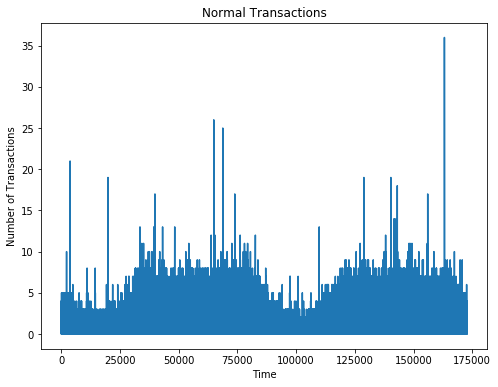

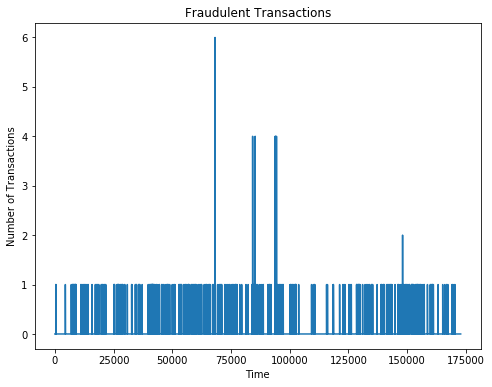

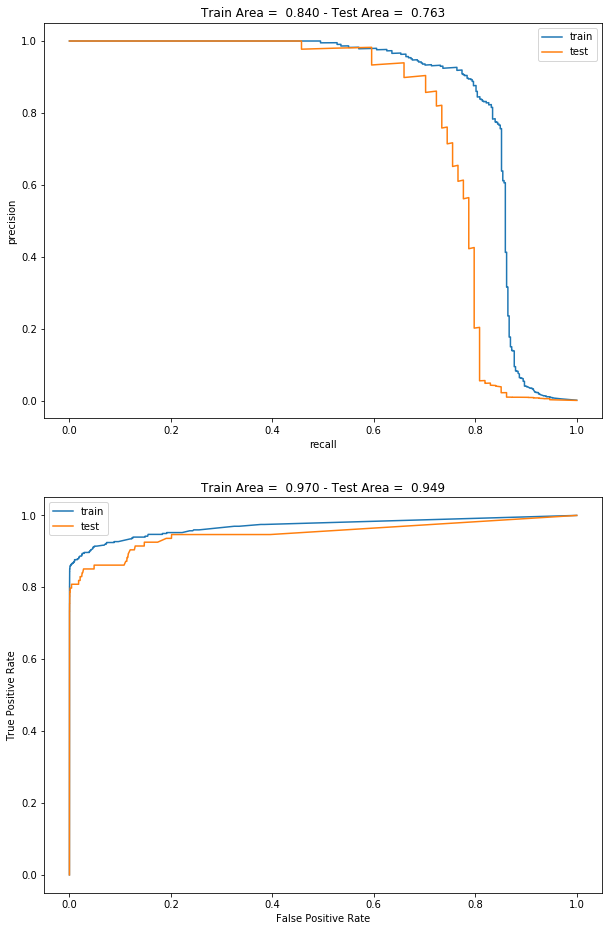

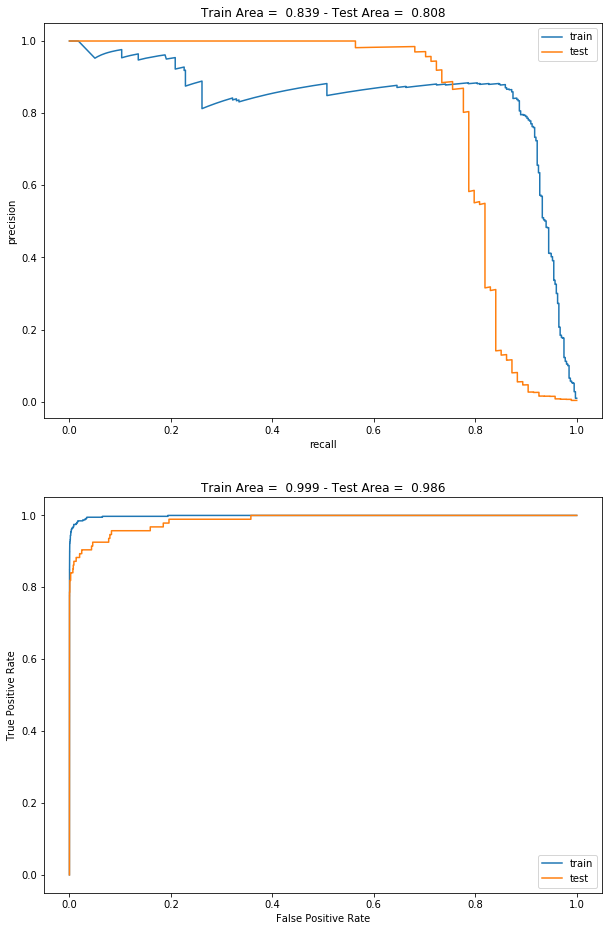

In [8]:
s3accessKey=''
s3secretKey=''
s3endpointUrl=''
trainingdata = ""
s3objectStoreLocation=''
outputmodel=''


TRAINING_DATA='creditcard.csv'

#Download training data

session = boto3.Session(aws_access_key_id=s3accessKey, aws_secret_access_key=s3secretKey)
s3 = session.resource('s3', endpoint_url=s3endpointUrl, verify=False)
s3.meta.client.download_file(s3objectStoreLocation, trainingdata, TRAINING_DATA)

df = pd.read_csv('creditcard.csv')
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')
print("First row: ")
df.iloc[0]
print("Distribution of values for 'Class':")
df['Class'].value_counts()

#Exploratory Time-series Analysis¶

#count number of transactions in each class for each time-period
n_trans_time = df.groupby(['Class', 'Time']).count()

n_trans_time = pd.concat([n_trans_time.loc[0][['Amount']], n_trans_time.loc[1][['Amount']]], axis=1).fillna(0)
n_trans_time.columns = ['Normal', 'Fraud']
n_trans_time.sort_index(inplace=True)

#fill gaps in time
index_vals = np.array(n_trans_time.index)
new_index_vals = np.arange(0, np.max(index_vals))

df_new_index = pd.DataFrame(np.ones(len(new_index_vals)), index=new_index_vals)

n_trans_time = pd.concat([n_trans_time, df_new_index], axis=1).fillna(0).drop(0, axis=1)


plt.figure(figsize=(8,6))
_ = plt.plot(n_trans_time.index, n_trans_time['Normal'])
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.title('Normal Transactions')

plt.figure(figsize=(8,6))
_ = plt.plot(n_trans_time.index, n_trans_time['Fraud'])
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.title('Fraudulent Transactions')

#Correlation

print('Compute correlation coefficient between the two time-series (Normal and Fraud)')
corr = np.corrcoef(n_trans_time['Fraud'], n_trans_time['Normal'])

print(f'Correlation = {corr[1][0]}')

print('Negligible correlation')


#MODEL TRAINING

df_train, df_test = create_validation_sets(df, train_size=0.75)

print('Distribution of target variable in train: ')
df_train['Class'].value_counts()

print('Distribution of target variable in test: ')
df_test['Class'].value_counts()

print('Ratio of Class 0 between train and test:')
print(f'213207 / 71108 = {213207 / 71108}')


print('Ratio of Class 1 between train and test:')
print(f'398 / 94 = {398 / 94}')

features_train = df_train.drop(['Time', 'Class'], axis=1)
target_train = df_train['Class']

features_test = df_test.drop(['Time', 'Class'], axis=1)
target_test = df_test['Class']

model_rf = RandomForestClassifier(n_estimators=100, 
                                  max_depth=4, 
                                  n_jobs=10)
model_rf = build_model(model_rf, features_train, target_train,
                                 features_test, target_test)


#Random Forest (accounting for class imbalance)¶
model_rf_balanced = RandomForestClassifier(n_estimators=200, 
                                           max_depth=6, 
                                           n_jobs=10, 
                                           class_weight='balanced')

model_rf_balanced = build_model(model_rf_balanced, features_train, target_train,
                                features_test, target_test)


#Save the model

filename = 'model.pkl'
joblib.dump(model_rf_balanced, filename)

#Copy trained model to S3 backend

s3.meta.client.upload_file(filename, s3objectStoreLocation, outputmodel)
